### Импортируем библиотеки

In [1]:
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
import os
from math import log as log
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif

import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import datetime
from sklearn.preprocessing import PolynomialFeatures
from itertools import combinations
from scipy.stats import ttest_ind
from sklearn.model_selection import GridSearchCV
%matplotlib inline


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [4]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

In [5]:
train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
test = pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')
sample_sub = pd.read_csv('/kaggle/input/sf-dst-scoring/sample_submission.csv')

In [6]:
train.head(2)

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      25905  01FEB2014       SCH   M   62   Y        Y                0   
1      63161  12MAR2014       SCH   F   59   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.008753                1             50             1   
1          0  -1.532276                3             50             2   

   work_address  income  sna  first_time foreign_passport  default  
0             2   18000    4           1                N        0  
1             3   19000    4           1                N        0

Получим информацию о датасетах

In [7]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

(None, None)

In [8]:
train.columns, test.columns

(Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
        'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
        'region_rating', 'home_address', 'work_address', 'income', 'sna',
        'first_time', 'foreign_passport', 'default'],
       dtype='object'),
 Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
        'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
        'region_rating', 'home_address', 'work_address', 'income', 'sna',
        'first_time', 'foreign_passport'],
       dtype='object'))

Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

Проверим наличие пропусков в датасете

In [9]:
train.isnull().sum(), test.isnull().sum()

(client_id             0
 app_date              0
 education           307
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 default               0
 dtype: int64,
 client_id             0
 app_date              0
 education           171
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 dtype: int64)

Для наглядности посмотрим на данный признак на графике

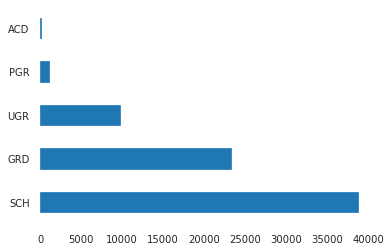

In [10]:
train['education'].value_counts().plot.barh()

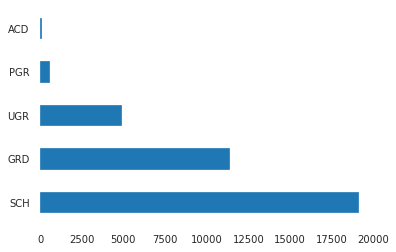

In [11]:
test['education'].value_counts().plot.barh()

In [12]:
#размерность тренировочного датасета
train.shape

(73799, 19)

In [13]:
#размерность тестового датасета
test.shape

(36349, 18)

In [14]:
test.describe()

client_id           age  decline_app_cnt     good_work  \
count   36349.000000  36349.000000     36349.000000  36349.000000   
mean    54945.647473     39.186002         0.268040      0.166772   
std     31706.052195     11.513258         0.788478      0.372777   
min         4.000000     21.000000         0.000000      0.000000   
25%     27744.000000     30.000000         0.000000      0.000000   
50%     54657.000000     37.000000         0.000000      0.000000   
75%     82322.000000     48.000000         0.000000      0.000000   
max    110148.000000     71.000000        30.000000      1.000000   

          score_bki  bki_request_cnt  region_rating  home_address  \
count  36349.000000     36349.000000   36349.000000  36349.000000   
mean      -1.904152         2.014471      56.802938      1.573798   
std        0.501764         2.296789      13.086646      0.527428   
min       -3.574197         0.000000      20.000000      1.000000   
25%       -2.261909         0.000000      50.000000      1.000000   
50%       -1.920823         1.000000      50.000000      2.000000   
75%       -1.563957         3.000000      60.000000      2.000000   
max        0.188820        47.000000      80.000000      3.000000   

       work_address          income           sna    first_time  
count  36349.000000    36349.000000  36349.000000  36349.000000  
mean       2.501087    40835.755729      1.728053      2.765798  
std        0.683227    43802.180951      1.120686      1.011560  
min        1.000000     1000.000000      1.000000      1.000000  
25%        2.000000    20000.000000      1.000000      2.000000  
50%        3.000000    30000.000000      1.000000      3.000000  
75%        3.000000    48000.000000      2.000000      4.000000  
max        3.000000  1000000.000000      4.000000      4.000000

In [15]:
train.describe()

client_id           age  decline_app_cnt     good_work  \
count   73799.000000  73799.000000     73799.000000  73799.000000   
mean    55137.965094     39.280641         0.275749      0.164894   
std     31841.921168     11.520378         0.804272      0.371087   
min         1.000000     21.000000         0.000000      0.000000   
25%     27440.500000     30.000000         0.000000      0.000000   
50%     55274.000000     37.000000         0.000000      0.000000   
75%     82758.500000     48.000000         0.000000      0.000000   
max    110147.000000     72.000000        33.000000      1.000000   

          score_bki  bki_request_cnt  region_rating  home_address  \
count  73799.000000     73799.000000   73799.000000  73799.000000   
mean      -1.904724         2.000339      56.725701      1.575509   
std        0.498231         2.252073      13.055717      0.527631   
min       -3.624586         0.000000      20.000000      1.000000   
25%       -2.259534         0.000000      50.000000      1.000000   
50%       -1.920823         1.000000      50.000000      2.000000   
75%       -1.569831         3.000000      60.000000      2.000000   
max        0.199773        53.000000      80.000000      3.000000   

       work_address          income           sna    first_time       default  
count  73799.000000    73799.000000  73799.000000  73799.000000  73799.000000  
mean       2.496280    41099.775417      1.733330      2.765458      0.126994  
std        0.689818    46166.322400      1.123622      1.009463      0.332968  
min        1.000000     1000.000000      1.000000      1.000000      0.000000  
25%        2.000000    20000.000000      1.000000      2.000000      0.000000  
50%        3.000000    30000.000000      1.000000      3.000000      0.000000  
75%        3.000000    48000.000000      2.000000      4.000000      0.000000  
max        3.000000  1000000.000000      4.000000      4.000000      1.000000

данные в тестовой и тренировочных выборках схожи по метрикам (std, mean, min, max, percentile)
для корректной обработки признаков объединяем два датасета в один
но необходимо учесть,что в тестовой выборке нет колонки default 

In [16]:
#помечаем дата сеты (где тест, где  треин)
train['sample'] = 1 
test['sample'] = 0 
test['default'] = 0 # в тесте у нас нет значения default, просто заполняем нулями
# объединяем
data = test.append(train, sort=False).reset_index(drop=True) 

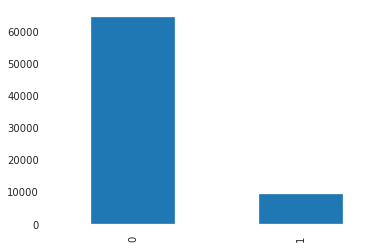

In [17]:
train['default'].value_counts().plot.bar()

In [18]:
можно сделать сразу вывод, что целевая переменная несбалансирована, 
что может негативно сказаться на рузультатах обучения модели

SyntaxError: invalid syntax (<ipython-input-18-ebd9c56eab2c>, line 1)

In [19]:
data

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0           74835  22MAR2014       GRD   M   29   Y        Y                0   
1           17527  24JAN2014       SCH   F   39   N        N                5   
2           75683  23MAR2014       UGR   M   50   Y        Y                0   
3           26883  03FEB2014       SCH   M   56   N        N                0   
4           28862  04FEB2014       GRD   F   38   N        N                0   
...           ...        ...       ...  ..  ...  ..      ...              ...   
110143      54887  04MAR2014       GRD   F   45   N        N                0   
110144      76821  24MAR2014       SCH   M   41   Y        Y                0   
110145     103695  22APR2014       SCH   M   31   N        N                0   
110146        861  04JAN2014       SCH   F   29   N        N                0   
110147      15796  23JAN2014       GRD   M   34   N        N                0   

        good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0               0  -2.271884                3             50             1   
1               0  -1.504999                2             50             1   
2               0  -1.691339                1             50             1   
3               0  -2.374182                1             40             1   
4               0  -2.487502                0             80             2   
...           ...        ...              ...            ...           ...   
110143          0  -1.792064                3             50             1   
110144          0  -2.058029                1             50             2   
110145          0  -1.512635                4             80             2   
110146          1  -1.479334                3             50             1   
110147          0  -1.764711                2             50             2   

        work_address  income  sna  first_time foreign_passport  sample  \
0                  2   50000    1           4                N       0   
1                  2    5000    4           3                N       0   
2                  2   30000    1           3                Y       0   
3                  2   17000    1           3                N       0   
4                  3  120000    1           3                N       0   
...              ...     ...  ...         ...              ...     ...   
110143             2   17000    4           4                N       1   
110144             2   70000    1           4                N       1   
110145             3   45000    2           2                N       1   
110146             3   13000    2           3                N       1   
110147             3   25000    1           3                N       1   

        default  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
110143        0  
110144        0  
110145        0  
110146        1  
110147        0  

[110148 rows x 20 columns]

# АНАЛИЗ ДАННЫХ

In [20]:
#рассмотрим получше полученные данные
pandas_profiling.ProfileReport(data)

На основе ProfileReport можно сделать выводы:
* колонка education имеет 478 пустых строк
* категорий типа Numeric - 6, Categorical-  5, Boolean -5.
* только у половны людей из выборки есть машина
* поле decline_app_cnt  имеет 83% нулевых значений
* только 20% из выборки имеют хорошую работу
* bki_request_cnt имеет  26% нулевых значений
* давность наличия информации о заемщике (first time)
* score_bki имеет нормальное распредление, другие признаки типа Numeric таким не обладают
* first_time имеет высокую обратную зависимость с sna
* Целевая переменная default сильно несбалансирована
* Колонка app_date имеет формат дата


In [21]:
#делим наши признаки на котегориальные, бинарные, и числовые
bin_cols = ['sex', 'car', 'car_type',  'foreign_passport', 'good_work']
cat_cols = ['education',  'home_address', 'work_address','first_time','sna']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki','region_rating']
date_cols = ['app_date']

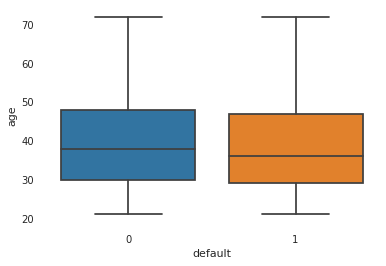

In [22]:
#расмотрим боксплоты по дефолтным клиентам на тренировочной выборке
sns.boxplot(x=data[data['sample']==1].default, y=data[data['sample']==1].age)

Недефолтные клиенты в среднем старше дефолтных

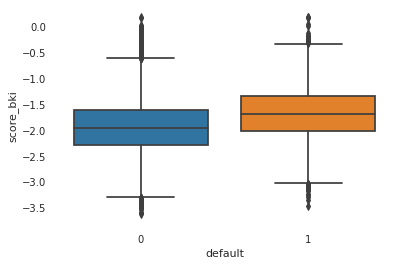

In [23]:
sns.boxplot(x=data[data['sample']==1].default, y=data[data['sample']==1].score_bki)

Скоринговый балл в среднем выше у дефолтных клиентов, что довольно необычно (вероятнее всего банк самостоятельно произвел манипуляции с этим признаком, т. к. обычно скоринговый балл положительный от 0 до 850)



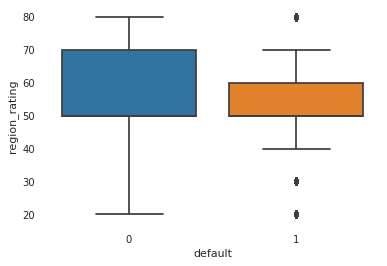

In [24]:
sns.boxplot(x=data[data['sample']==1].default, y=data[data['sample']==1].region_rating)


Чем больше рейтинг у региона , тем меньше дефолтных клиентов

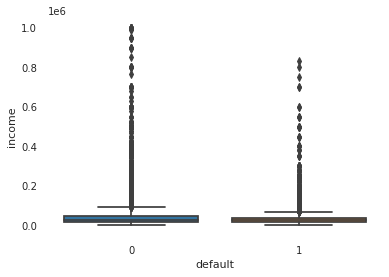

In [25]:
sns.boxplot(x=data[data['sample']==1].default, y=data[data['sample']==1].income)


Доход недефолтных клиентов выше, чем доход дефолтных

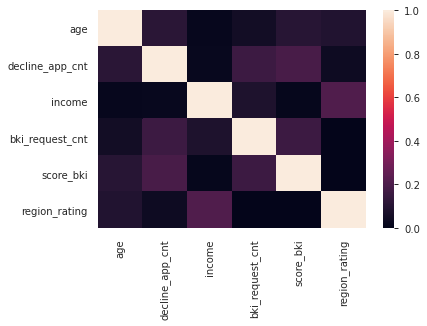

In [26]:
#посмотрим корреляцию числовых признаков
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

наблюдается зависимость между income и region_rating.Т.е чем выше рейтинг региона, 
тем выше доход граждан
также наблюдается зависимость между score_bki и decline_app_cnt

# **ПОДГОТОВКА ДАННЫХ**

In [27]:
#заполняем пустые строки в поле образования на "without" -т.е без образования
data.education = data.education.fillna('without')

Проверим успешность заполнения

In [28]:
data.isnull().sum()

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
sample              0
default             0
dtype: int64

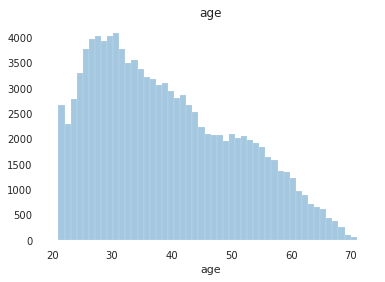

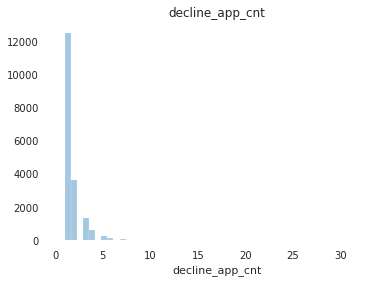

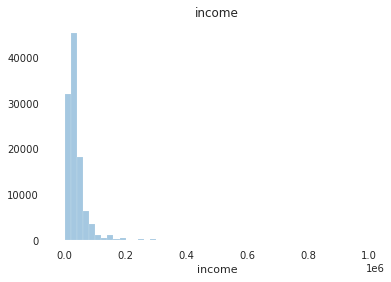

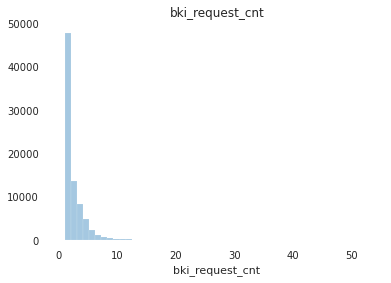

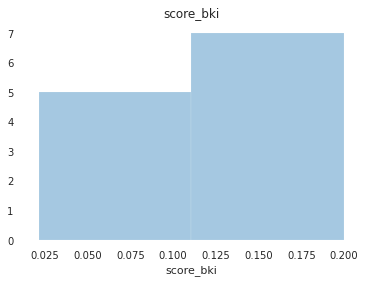

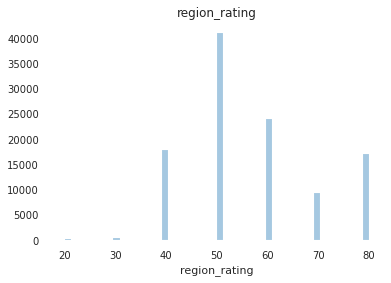

In [29]:
#еще раз посмотрим на распрделение числовых признаков
for i in num_cols:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

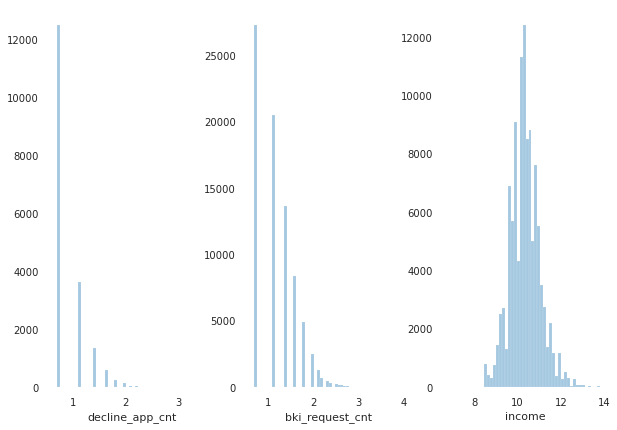

In [30]:
# необходимо нормализовать данные колонок decline_app_cnt, bki_request_cnt, income 
fig, axes = plt.subplots(1, 3, figsize=(10,7))
for i,col in enumerate(['decline_app_cnt', 'bki_request_cnt', 'income']):
    data[col] = np.log(data[col] + 1)
    sns.distplot(data[col][data[col] > 0].dropna(), ax=axes.flat[i],kde = False, rug=False)

Взглянем поближе на признак app_date

In [31]:
data.app_date.head(5)

0    22MAR2014
1    24JAN2014
2    23MAR2014
3    03FEB2014
4    04FEB2014
Name: app_date, dtype: object

Сконветируем формат даты к удобному для работы

In [32]:
data.app_date = pd.to_datetime(data.app_date)
data.app_date.head(2)

0   2014-03-22
1   2014-01-24
Name: app_date, dtype: datetime64[ns]

На основе признака app_date создадим новые признаки

In [33]:
current_date = pd.to_datetime(date.today())

In [34]:
# Количество дней, прошедших со дня подачи заявки
data['days_passed'] = (current_date - data.app_date).dt.days
num_cols.append('days_passed')

созданим новый бинарный признак: были ли отклонены док-ты или нет

In [35]:
def is_not_zero(x):
    if x == 0:
        return x
    else:
        return 1
data['was_declined'] = data['decline_app_cnt'].apply(lambda x: is_not_zero(x))
bin_cols.append('was_declined')


уменьшим кол-во признаков по полю bki_request_cnt

In [36]:
data['bki_request_cnt'].unique()

array([1.38629436, 1.09861229, 0.69314718, 0.        , 2.07944154,
       1.79175947, 1.60943791, 1.94591015, 2.30258509, 2.19722458,
       2.56494936, 2.39789527, 2.89037176, 2.63905733, 2.48490665,
       2.7080502 , 2.77258872, 2.99573227, 3.33220451, 2.94443898,
       2.83321334, 3.40119738, 3.09104245, 3.04452244, 3.87120101,
       3.13549422, 3.17805383, 3.25809654, 3.52636052, 3.21887582,
       3.49650756, 3.71357207, 3.29583687, 3.36729583, 3.55534806,
       3.61091791, 3.98898405, 3.8286414 , 3.73766962, 3.8501476 ])

In [37]:
def count_req(x):
    if x == 0:
        return 0
    if 2 >=x >= 1:
        return 1
    else:
        return 2
data['cat_bki_request_cnt'] = data['bki_request_cnt'].apply(lambda x: count_req(x))
cat_cols.append('cat_bki_request_cnt')

In [38]:
data.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'sample', 'default', 'days_passed',
       'was_declined', 'cat_bki_request_cnt'],
      dtype='object')

In [39]:
#добавим новые признаки в наши разбивки
bin_cols.append('was_declined')
cat_cols.append('cat_bki_request_cnt')
num_cols.append('days_passed')

In [40]:
#преобразуем поле education
education_dict = {'without':0, 'SCH':1, 'GRD':2, 'UGR':3, 'PGR':4, 'ACD':5}
data.education = data.education.replace(to_replace=education_dict)

In [41]:
# Для бинарных и категориальных признаков используем LabelEncoder
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

client_id   app_date  education  sex  age  car  car_type  decline_app_cnt  \
0      74835 2014-03-22          2    1   29    1         1         0.000000   
1      17527 2014-01-24          1    0   39    0         0         1.791759   
2      75683 2014-03-23          3    1   50    1         1         0.000000   
3      26883 2014-02-03          1    1   56    0         0         0.000000   
4      28862 2014-02-04          2    0   38    0         0         0.000000   

   good_work  score_bki  ...  work_address     income  sna  first_time  \
0          0  -2.271884  ...             2  10.819798    1           4   
1          0  -1.504999  ...             2   8.517393    4           3   
2          0  -1.691339  ...             2  10.308986    1           3   
3          0  -2.374182  ...             2   9.741027    1           3   
4          0  -2.487502  ...             3  11.695255    1           3   

   foreign_passport  sample  default  days_passed  was_declined  \
0                 0       0        0         2569             0   
1                 0       0        0         2626             1   
2                 1       0        0         2568             0   
3                 0       0        0         2616             0   
4                 0       0        0         2615             0   

   cat_bki_request_cnt  
0                    1  
1                    1  
2                    2  
3                    2  
4                    0  

[5 rows x 23 columns]

In [42]:
# Преобразуем категориальные признаки и снова разделим данные на тренировочный и тестовый наборы
X_cat = OneHotEncoder(sparse = False).fit_transform(data[data['sample'] == 1][cat_cols + bin_cols].values)
X_cat_test = OneHotEncoder(sparse = False).fit_transform(data[data['sample'] == 0][cat_cols + bin_cols].values)

In [43]:
# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(data[data['sample'] == 1][num_cols].values)
X_num_test = StandardScaler().fit_transform(data[data['sample'] == 0][num_cols].values)

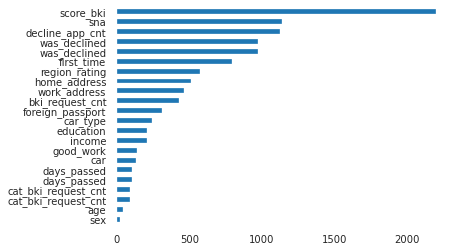

In [44]:
# Проанализируем значимость признаков
imp_num = pd.Series(f_classif(data[num_cols + bin_cols + cat_cols], data['default'])[0], index = num_cols + bin_cols + cat_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')


In [45]:
# Объединяем
X = np.hstack([X_num, X_cat])
Y = data[data['sample'] == 1]['default'].values

In [46]:
X_test = np.hstack([X_num_test, X_cat_test])
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.20, random_state=42)

In [47]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((59039, 48), (59039,), (14760, 48), (14760,))

# Создание наивной модели 

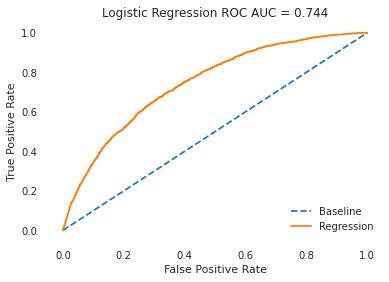

In [48]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_valid)
probs = probs[:,1]
y_pred = model.predict(X_valid)
y_pred_prob = model.predict_proba(X_valid)[:,1]

fpr, tpr, threshold = roc_curve(y_valid, probs)
roc_auc = roc_auc_score(y_valid, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [49]:
print('NAIVE Model\n')
print('accuracy_score:',accuracy_score(y_valid,y_pred))
print('precision_score:',precision_score(y_valid,y_pred))
print('recall_score:',recall_score(y_valid,y_pred))
print('f1_score:',f1_score(y_valid,y_pred))

NAIVE Model

accuracy_score: 0.8751355013550135
precision_score: 0.4148936170212766
recall_score: 0.021346469622331693
f1_score: 0.040603852160333166


[Text(0, 0.5, 'True'), Text(0.5, 0, 'Predicted')]

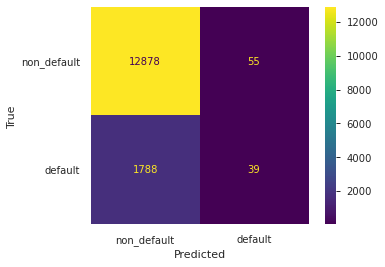

In [50]:
cm = confusion_matrix(y_valid, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['non_default','default'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

Резюме: модель почти не угадала реальных дефолтных клиентов, тем самым обеспечили себе огромную ошибку второго рода и как следствие убыток, но ROC-AUC у нас высокий. Только метрика f1 сигнализирует о том, что что-то не впорядке. Попробуем сбалансировать параметры модели.

# Настройка гиперпараметров


In [51]:
C = [0.1, 1, 10]
penalty = ['l2']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
class_weight = ['balanced', {1:0.7, 0:0.3}]

param = dict(penalty=penalty, solver=solver, class_weight=class_weight, C=C)

gridsearch = GridSearchCV(model, param_grid=param, scoring='f1', n_jobs=-1, cv=5)
grid_result = gridsearch.fit(X_train, y_train)

# Печать лучших параметров
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.3391387941291053
Best Params:  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}


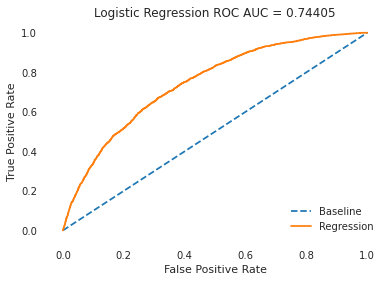

In [52]:
# модель после оптимизации
model = LogisticRegression(random_state=42, C=10, penalty='l2', class_weight={
                            1: 0.7, 0: 0.3}, solver='newton-cg', max_iter=1000)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_valid)[:, 1]

y_pred = model.predict(X_valid)
fpr, tpr, threshold = roc_curve(y_valid, y_pred_proba)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [53]:
print('NAIVE Model\n')
print('accuracy_score:',accuracy_score(y_valid,y_pred))
print('precision_score:',precision_score(y_valid,y_pred))
print('recall_score:',recall_score(y_valid,y_pred))
print('f1_score:',f1_score(y_valid,y_pred))

NAIVE Model

accuracy_score: 0.8578590785907859
precision_score: 0.3675464320625611
recall_score: 0.20580186097427478
f1_score: 0.263859649122807


[Text(0, 0.5, 'True'), Text(0.5, 0, 'Predicted')]

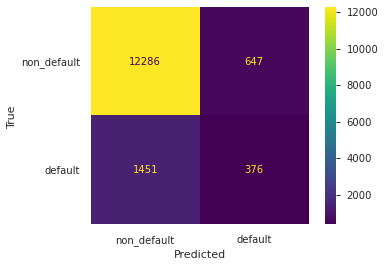

In [54]:
cm = confusion_matrix(y_valid, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['non_default','default'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

Резюме: в случае с несбалансированной целевой переменной получаются низкие значения метрики f1-score. При этом возникает большое значение ошибок первого рода. Оптимизация гиперпараметров приводило матрицу к более адекватному виду и повышению метрики f1-score. 

# Submit

In [55]:
test_data = np.hstack([X_num_test, X_cat_test])


In [56]:
predict_submission = model.predict_proba(test_data)[:,1]
predict_submission

array([0.08570779, 0.54726406, 0.12853106, ..., 0.54253537, 0.3935711 ,
       0.44093497])

In [57]:
ids = pd.read_csv('../input/sf-dst-scoring/test.csv')

In [58]:
sample_submission = pd.DataFrame(columns = ['client_id','default'])
sample_submission['client_id'] = ids.client_id
sample_submission['default'] = predict_submission
sample_submission

client_id   default
0          74835  0.085708
1          17527  0.547264
2          75683  0.128531
3          26883  0.195498
4          28862  0.059749
...          ...       ...
36344      83775  0.544339
36345     106254  0.038413
36346      81852  0.542535
36347       1971  0.393571
36348      69044  0.440935

[36349 rows x 2 columns]

In [59]:
sample_submission.to_csv('submission.csv', index=False)